In [63]:
"""This module implements the Fréchet regression method from Petersen and Müller 2019.

The method is implemented in the context of estimation in the space of distribution
functions. Also, a simulation study is designed to compare with the methods outlined in
Petersen and Müller 2016.

"""

'This module implements the Fréchet regression method from Petersen and Müller 2019.\n\nThe method is implemented in the context of estimation in the space of distribution\nfunctions. Also, a simulation study is designed to compare with the methods outlined in\nPetersen and Müller 2016.\n\n'

In [64]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

from frechet_fda.function_class import Function

In [94]:
N = 200
predictor = np.random.uniform(-1, 1, (2, N)) # for case of multiple predictors
predictor = np.random.uniform(-1, 1, N)

In [95]:
def mu_from_x(x, mu0, beta, v1):
    """Sample mus from the first simulation setting in Petersen & Müller (2019)."""

    return np.random.normal(loc = mu0 + beta * x, scale = v1)

In [96]:
mus = mu_from_x(predictor, 0, 3, 0.25)

In [97]:
def sigma_from_x(x, sigma0, gamma, v2):
    """Sample sigmas from the first simulation setting Petersen & Müller (2019)."""
    sh = (sigma0 + gamma * x) ** 2 / v2
    sc = v2 / (sigma0 + gamma * x)

    return np.random.gamma(shape=sh, scale=sc)

In [98]:
sigmas = sigma_from_x(predictor, 3, 0.5, 2)

In [99]:
grid_size = 2000
u = np.linspace(0, 1, grid_size)

In [100]:
def gen_y_qf(mu, sigma, eval_points):
    """Generate quantile function of Y_i given X_i."""
    return mu[..., np.newaxis] + sigma[..., np.newaxis] * norm.ppf(eval_points)[np.newaxis, ...]

In [101]:
ys = gen_y_qf(mu = mus, sigma = sigmas, eval_points = u)

In [102]:
ys.shape

(200, 2000)

In [103]:
qfs = [Function(u, y) for y in ys]

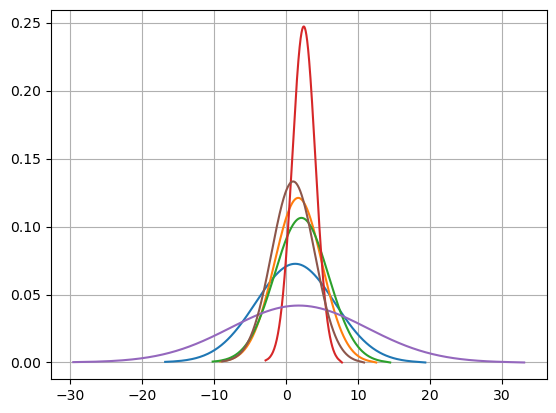

In [104]:
fig, ax = plt.subplots()
for qf in qfs[:6]:
    pdf = qf.invert().differentiate()
    ax.plot(
    pdf.x,
    pdf.y,
)
plt.grid()
plt.show()

In [125]:
def _empirical_weight_function(x, predictor_values):
    predictor_values = np.atleast_2d(predictor_values)
    means = np.mean(predictor_values, axis = -1)
    cov_matrix = (
        predictor_values @ predictor_values.transpose()
        / predictor_values.shape[-1]
    )
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    s_in = 1 + (
        (predictor_values - means[..., np.newaxis]).transpose()
        @ inv_cov_matrix
        @ (x - means)
    )
    return s_in

In [128]:
from frechet_fda.tools.function_tools import mean_func

In [129]:
def g_x_hat(quantile_funcs, x, predictor_values):
    """Estimator??"""
    return mean_func(_empirical_weight_function(x, predictor_values) * quantile_funcs)

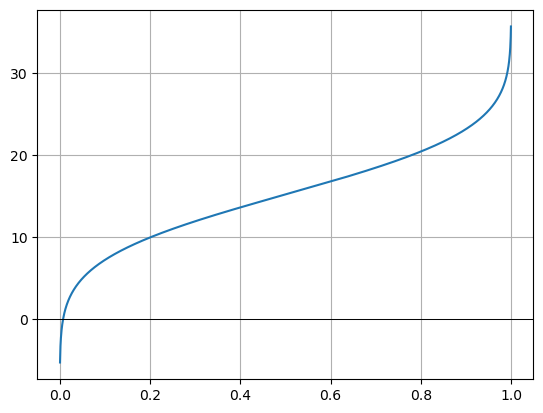

In [134]:
g_x_hat(qfs, 5, predictor).plot()